In [17]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
base_path = "/content/drive/My Drive/Deep_Learning_Assignments/Assignment3/q3/"
fig_path = "/content/drive/My Drive/Deep_Learning_Assignments/Assignment3/q3/Figures/shallow_dann/"
# base_path = "/content/drive/My Drive/Deep_Learning_Assignments/Assignment3/"
# base_path = "/content/gdrive/My Drive/Deep_Learning_Assignments/Assignment3/q3/"
repo_path = base_path+"Repo_folder"
model_root = base_path+'models'

In [0]:
import os
import time
import numpy as np
from math import sqrt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
# from DANN import DANN

from matplotlib import pyplot
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split

In [0]:
import random
import os
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
# from data_loader import GetLoader
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
# from model import CNNModel
import numpy as np
# from test import test


import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split

In [0]:
def make_trans_moons(theta=40, nb=100, noise=.05):
    #to generate dataset
    from math import cos, sin, pi
    
    X, y = make_moons(nb, noise=noise, random_state=1)
    # pyplot.plot(X)
    # pyplot.show()
    Xt, yt = make_moons(nb, noise=noise, random_state=2)
    # print(X[0])
    shape_prev = X.shape
    trans = -np.mean(X, axis=0) #translation
    X  = 2*(X+trans)
    Xt = 2*(Xt+trans)
    shape_now = X.shape

    print(shape_prev,shape_now)

    theta = -theta*pi/180
    rotation = np.array( [  [cos(theta), sin(theta)], [-sin(theta), cos(theta)] ] )
    Xt = np.dot(Xt, rotation.T)
    
    return X, y, Xt, yt

In [0]:
def draw_trans_data(X, y, Xt, predict_fct=None, neurons_to_draw=None, colormap_index=0, special_points=None, special_xytext=None):
    # Some line of codes come from: http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

    if colormap_index==0:
        cm_bright = ListedColormap(['#FF0000', '#00FF00'])
    else:
        cm_bright = ListedColormap(['#0000FF', '#000000'])

    x_min, x_max = 1.1*X[:, 0].min(), 1.1*X[:, 0].max()
    y_min, y_max = 1.5*X[:, 1].min(), 1.5*X[:, 1].max()
        
    pyplot.xlim((x_min,x_max))
    pyplot.ylim((y_min,y_max))
    
    pyplot.tick_params(direction='in', labelleft=False)    

    if predict_fct is not None:
        h = .02  # step size in the mesh

        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        
        Z = predict_fct(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        pyplot.contourf(xx, yy, Z, cmap=cm_bright, alpha=.4)
        pyplot.contour(xx, yy, Z, colors='black', linewidths=5)

    cnt_0 =0; cnt_1 =0 
    if X is not None:
        for i in range(len(y)):
            if y[i] == 1:
                cnt_1+=1
                pyplot.annotate("-", X[i,:], color="green", size=50*1, textcoords='offset points', xytext=(-6*1.5,-13*1.5))
                # pyplot.annotate("-", X[i,:], color="green", size=40*1.5)
            else:
                cnt_0+=1
                pyplot.annotate("+", X[i,:], color="red", size=30*1, textcoords='offset points', xytext=(-8*1.5,-8*1.5))
                # pyplot.annotate("+", X[i,:], color="red", size=20*1.5)
    print("cnt_0",cnt_0,"cnt_1",cnt_1)
    if Xt is not None:
        pyplot.scatter(Xt[:, 0], Xt[:, 1], c='k', s=40)

    if special_points is not None:
        for i in range(np.shape(special_points)[0]):
            if special_xytext is None:
                xytext = (30,45) if i%2 == 1 else (-40,-60)
            else:
                xytext = special_xytext[i]
                
            pyplot.annotate('ABCDEFG'[i], special_points[i,:], xycoords='data', color="blue",
                xytext=xytext, textcoords='offset points',
                size=32,
                arrowprops=dict(arrowstyle="fancy", fc=(0., 0., 1.), ec="none", connectionstyle="arc3,rad=0.0"))
        
    if neurons_to_draw is not None:
        for w12, b in zip(neurons_to_draw[0], neurons_to_draw[1]):
            w1, w2 = w12
            get_y = lambda x: -(w1*x+b)/w2
            pyplot.plot([x_min,x_max], [get_y(x_min), get_y(x_max)])

In [0]:
def make_dataset(x,y):
    x_tensor = torch.from_numpy(x).float()
    y_tensor = torch.from_numpy(y).float()
    dataset = TensorDataset(x_tensor, y_tensor)
    return dataset


#Creating data, datasets and dataloaders

In [24]:
src_X, src_y, tgt_X, tgt_y = make_trans_moons(35, nb=300) #theta = 35,150 samples for each label
X_src_train, X_src_test, y_src_train, y_src_test =  train_test_split(src_X, src_y, test_size = 0.2, random_state = 42,shuffle = True)
X_tgt_train, X_tgt_test, y_tgt_train, y_tgt_test =  train_test_split(tgt_X, tgt_y, test_size = 0.2, random_state = 27,shuffle = True)
L= [ X_src_train, X_src_test, y_src_train, y_src_test ]

src_train_dataset = make_dataset(X_src_train,y_src_train)
src_test_dataset = make_dataset(X_src_test,y_src_test)
tgt_train_dataset = make_dataset(X_tgt_train,y_tgt_train)
tgt_test_dataset = make_dataset(X_tgt_test,y_tgt_test)

src_train_loader = DataLoader(dataset=src_train_dataset, batch_size=30)
src_test_loader = DataLoader(dataset=src_test_dataset, batch_size=30)
tgt_train_loader = DataLoader(dataset=tgt_train_dataset, batch_size=30)
tgt_test_loader = DataLoader(dataset=tgt_test_dataset, batch_size=30)
# for l in L:
#   print(len(l))

(300, 2) (300, 2)


In [0]:
# print(X[0])

In [0]:
from torch.autograd import Function


class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class ReverseLayerF_nn(Function):

    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output * 0
        return output, None        

In [0]:
class DANN(nn.Module):
  def __init__(self, adversarial_representation=True):
    super(DANN, self).__init__()
    self.adversarial_representation = adversarial_representation
    hidden = 15
    self.feature = nn.Sequential(
            nn.Linear(2,hidden),
            nn.Sigmoid()
            )
    self.lc = nn.Sequential(
            nn.Linear(hidden,2),
            nn.LogSoftmax(dim=1)
            )
    self.dc = nn.Sequential(
            nn.Linear(hidden,2),
            nn.LogSoftmax(dim=1)
            )

  def forward(self,x,alpha):
    feature = self.feature(x)
    if self.adversarial_representation:
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        domain_output = self.dc(reverse_feature)
    else:
        domain_output = self.dc(feature)
    class_output = self.lc(feature)
    return class_output,domain_output

  def forward1(self,x,alpha=0):
    feature = self.feature(x)
    if self.adversarial_representation:
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        domain_output = self.dc(reverse_feature)
    else:
        domain_output = self.dc(feature)
    class_output = self.lc(feature)
    return feature

  def predict(self,x,alpha=0):
        x = torch.from_numpy(x).float()
        x = x.to(device)
        class_output,domain_output = self.forward(x,alpha)
        # domain_pred = domain_output.data.max(1, keepdim=True)[1]
        label_pred = class_output.data.max(1, keepdim=True)[1]        
        return label_pred

  def predict_domain(self,x,alpha=0):
        x = torch.from_numpy(x).float() 
        x = x.to(device)   
        class_output,domain_output = self.forward(x,alpha)
        domain_pred = domain_output.data.max(1, keepdim=True)[1]
        # label_pred = class_output.data.max(1, keepdim=True)[1]        
        return domain_pred      

In [0]:
class NN(nn.Module):
  def __init__(self):
    super(NN, self).__init__()
    hidden = 15
    self.feature = nn.Sequential(
            nn.Linear(2,hidden),
            nn.Sigmoid()
            )
    self.lc = nn.Sequential(
            nn.Linear(hidden,2),
            nn.LogSoftmax(dim=1)
            )
    self.dc = nn.Sequential(
            nn.Linear(hidden,2),
            nn.LogSoftmax(dim=1)
            )

  def forward(self,x,alpha):
    feature = self.feature(x)
    reverse_feature = ReverseLayerF_nn.apply(feature)
    domain_output = self.dc(reverse_feature)
    class_output = self.lc(feature)
    return class_output,domain_output

  def predict(self,x,alpha=0):
        x = torch.from_numpy(x).float()
        x = x.to(device)
        class_output,domain_output = self.forward(x,alpha)
        # domain_pred = domain_output.data.max(1, keepdim=True)[1]
        label_pred = class_output.data.max(1, keepdim=True)[1]        
        return label_pred

  def predict_domain(self,x,alpha=0):
        x = torch.from_numpy(x).float() 
        x = x.to(device)   
        class_output,domain_output = self.forward(x,alpha)
        domain_pred = domain_output.data.max(1, keepdim=True)[1]
        # label_pred = class_output.data.max(1, keepdim=True)[1]        
        return domain_pred    

  # def forward1(self,x,alpha=0):
  #   feature = self.feature(x)
  #   # if self.adversarial_representation:
  #       reverse_feature = ReverseLayerF.apply(feature, alpha)
  #       domain_output = self.dc(reverse_feature)
  #   else:
  #       domain_output = self.dc(feature)
  #   class_output = self.lc(feature)
  #   return feature

#Training

In [0]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dann = DANN().to(device)

loss_class = torch.nn.NLLLoss().to(device)
loss_domain = torch.nn.NLLLoss().to(device)

In [0]:
def test_dann(model,dataset_name, epoch):
    assert dataset_name in ['src', 'tgt']

    
    batch_size = 30
    alpha = 0

    model_root = base_path+'models'
    if(dataset_name=="src"):
        dataloader = src_train_loader
    else:
        dataloader = tgt_train_loader        

    """ Dataloader built"""

    # """ training """

    # model = torch.load(os.path.join(
    #     model_root, 'newdann_tgtnistm_model_epoch_' + str(epoch) + '.pth'
    # ))
    # print(model)
    model = model.eval()


    # if cuda:
    model = model.to(device)

    len_dataloader = len(dataloader)
    data_target_iter = iter(dataloader)

    i = 0
    n_total = 0
    n_correct = 0
    domain_correct =0

    while i < len_dataloader:

        # test model using target data
        data_target = data_target_iter.next()
        t_img, t_label = data_target

        batch_size = len(t_label)
        # print("bs",batch_size)

        class_label = torch.LongTensor(batch_size)


        if(dataset_name=="src"):
            domain_label = torch.zeros(batch_size)
            domain_label = domain_label.long()
        else:
            domain_label = torch.ones(batch_size)
            domain_label = domain_label.long()          


        # if cuda:
        t_img = t_img.to(device)
        t_label = t_label.to(device)
        t_img = t_img.to(device)
        class_label = class_label.to(device)
        domain_label = domain_label.to(device)

        class_label.resize_as_(t_label).copy_(t_label)

        class_output, domain_output = model(x=t_img, alpha=alpha)

        domain_pred = domain_output.data.max(1, keepdim=True)[1]
        domain_correct += domain_pred.eq(domain_label.data.view_as(domain_pred)).cpu().sum()
        pred = class_output.data.max(1, keepdim=True)[1]
        n_correct += pred.eq(class_label.data.view_as(pred)).cpu().sum()
        n_total += batch_size

        i += 1

    accu = n_correct.data.numpy() * 1.0 / n_total
    accu_domain = domain_correct.data.numpy() * 1.0 / n_total
    print ('epoch: %d, accuracy of the %s dataset: %f' % (epoch, dataset_name, accu))
    print ('epoch: %d, Domain accuracy of the %s dataset: %f' % (epoch, dataset_name, accu_domain))
    return accu,accu_domain

In [31]:
import random
model = dann
n_epoch = 1000
domain_errs = []
train_errs = []
test_accus = []
max_accu = 0
lr = 0.0075

best_b = 0

model_root = base_path+'models'

# print(model.state_dict())

optimizer = optim.Adam(dann.parameters(), lr=lr)
for epoch in range(n_epoch):
    len_dataloader = min(len(src_train_loader), len(tgt_train_loader))
    data_source_iter = iter(src_train_loader)
    data_target_iter = iter(tgt_train_loader)

    i = 0
    tot_err = 0
    domain_err = 0
    label_err = 0    
    while i < len_dataloader:
        p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
        alpha = 2. / (1. + np.exp(-10 * p)) - 1
        
        # training model using source data
        data_source = data_source_iter.next()
        # print(data_source)
        s_img, s_label = data_source
        

        dann.zero_grad()
        dann.train()
        batch_size = len(s_label)
#          print("s_label",batch_size)

        # s_img = torch.FloatTensor(2)
        class_label = torch.LongTensor(batch_size)
        domain_label = torch.zeros(batch_size)
        domain_label = domain_label.long()

        # if to:device
        s_img = s_img.to(device)
        s_label = s_label.to(device)
        s_img = s_img.to(device)
        class_label = class_label.to(device)
        domain_label = domain_label.to(device)

        class_label.resize_as_(s_label).copy_(s_label)

        class_output, domain_output = dann(x=s_img, alpha=alpha)
        err_s_label = loss_class(class_output, class_label)
        err_s_domain = loss_domain(domain_output, domain_label)
        '''new'''
        # err_s_label.to(device)
        # err_s_domain.to(device)


        # training model using target data
        data_target = data_target_iter.next()
        t_img, _ = data_target

        batch_size = len(t_img)
        # print("t_label",batch_size)        

        domain_label = torch.ones(batch_size)
        domain_label = domain_label.long()

        # if to:device
        t_img = t_img.to(device)
        domain_label = domain_label.to(device)

        _, domain_output = dann(x=t_img, alpha=alpha)
        err_t_domain = loss_domain(domain_output, domain_label)
        err_t_domain.to(device)#added new
        err = err_t_domain + err_s_domain + err_s_label
        domain_err +=( err_t_domain + err_s_domain )
        label_err+= err_s_label
        tot_err+=err
        err.backward()
        optimizer.step()

        i += 1
        # if(i%==0):
        #     print ('epoch: %d, [iter: %d / all %d], err_s_label: %f, err_s_domain: %f, err_t_domain: %f' \
        #           % (epoch, i, len_dataloader, err_s_label.data.cpu().numpy(),
        #             err_s_domain.data.cpu().numpy(), err_t_domain.data.cpu().item()))
        #     print("total err: ",err.detach().cpu().numpy())
    # torch.save(dann, '{0}/newdann_mnist_mnistm_model_epoch_{1}.pth'.format(model_root, epoch))
    _,da1 = test_dann(model,"src", epoch)
    accu,da2 = test_dann(model,"tgt", epoch)
    domain_err = domain_err.detach().cpu().numpy()/len_dataloader
    tot_err = tot_err.detach().cpu().numpy()/len_dataloader
    domain_accu = (da1+da2)/2
    domain_errs.append(domain_err)
    train_errs.append(tot_err) # train errs list
    test_accus.append(accu)
    if(accu>max_accu):
        b = random.randint(1,10000)
        best_epoch = epoch
        max_accu = accu
        best_b = b
    # torch.save(dann, '{0}/newdann_mnist_mnistm_model_epoch_{1}.pth'.format(model_root, epoch))      
        # torch.save(dann, ('{0}/'+str(b)+'shallow_dann_epoch_{1}.pth').format(model_root, epoch))

    print(" label err: ",label_err.detach().cpu().numpy()//len_dataloader,"domain err: ",domain_err, " domain accuracy: ", domain_accu)
print('done')

Streaming output truncated to the last 5000 lines.
epoch: 0, accuracy of the tgt dataset: 0.883333
epoch: 0, Domain accuracy of the tgt dataset: 1.000000
 label err:  0.0 domain err:  1.3937628269195557  domain accuracy:  0.5
epoch: 1, accuracy of the src dataset: 0.783333
epoch: 1, Domain accuracy of the src dataset: 0.891667
epoch: 1, accuracy of the tgt dataset: 0.887500
epoch: 1, Domain accuracy of the tgt dataset: 0.000000
 label err:  0.0 domain err:  1.3873767852783203  domain accuracy:  0.44583333333333336
epoch: 2, accuracy of the src dataset: 0.795833
epoch: 2, Domain accuracy of the src dataset: 0.387500
epoch: 2, accuracy of the tgt dataset: 0.883333
epoch: 2, Domain accuracy of the tgt dataset: 0.612500
 label err:  0.0 domain err:  1.3857486248016357  domain accuracy:  0.5
epoch: 3, accuracy of the src dataset: 0.800000
epoch: 3, Domain accuracy of the src dataset: 0.483333
epoch: 3, accuracy of the tgt dataset: 0.883333
epoch: 3, Domain accuracy of the tgt dataset: 0.550

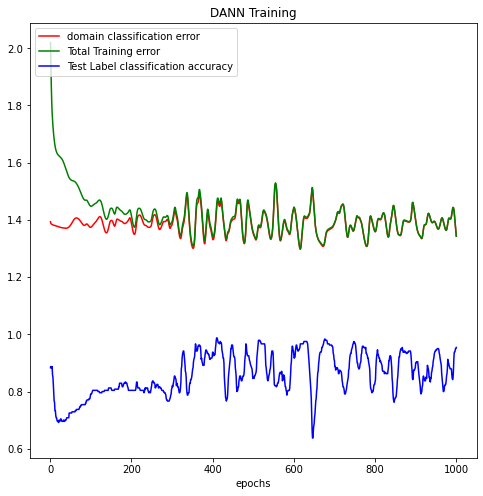

In [32]:
#plots : total error vs epochs, domain error vs epochs, test accuracy vs epochs
fig_width = 12
fig_height = 12
fig_dims = [fig_width,fig_height]
mode = "dann"
import matplotlib.pyplot as plt
epochs = np.arange(1,n_epoch+1)
plt.figure(1,figsize = fig_dims)
plt.title("DANN Training")
plt.xlabel('epochs' )
plt.plot(epochs,domain_errs,'r',label="domain classification error")
plt.plot(epochs,train_errs,'g', label = "Total Training error")
plt.plot(epochs,test_accus,'b',label = "Test Label classification accuracy")
plt.legend(loc="upper left")
save_name = "DANN_training_plot"
fig_name = fig_path + str(mode) + '_' + str(save_name) + '.png'
plt.savefig(fig_name)
# plt.figure()
# plt.title("Accuracy on Test set vs epochs")
# plt.xlabel('epochs')
# plt.ylabel('Test set accuracy')
# save_name = "Test_set_accuracy"
# fig_name = fig_path + str(mode) + '_' + str(save_name) + '.png'
# plt.savefig(fig_name)
# plt.plot(epochs,test_accus)

In [0]:
# #plots : total error vs epochs, domain error vs epochs, test accuracy vs epochs
# mode = "dann"
# import matplotlib.pyplot as plt
# epochs = np.arange(1,n_epoch+1)
# plt.figure()
# plt.title("domain_err vs epochs")
# plt.xlabel('epochs' )
# plt.ylabel('domain err')
# plt.plot(epochs,domain_errs)
# save_name = "domain_err"
# fig_name = fig_path + str(mode) + '_' + str(save_name) + '.png'
# plt.savefig(fig_name)
# plt.figure()
# plt.title("Accuracy on Test set vs epochs")
# plt.xlabel('epochs')
# plt.ylabel('Test set accuracy')
# save_name = "Test_set_accuracy"
# fig_name = fig_path + str(mode) + '_' + str(save_name) + '.png'
# plt.savefig(fig_name)
# plt.plot(epochs,test_accus)

In [0]:
model =  torch.load(os.path.join(
        model_root, '3706shallow_dann_epoch_996.pth'
    ))
best_epoch = 996

print("Best epoch",best_epoch,"lr: ",lr,"best_b: ",best_b)
_,da1 = test_dann(model,"src", best_epoch)
accu,da2 = test_dann(model,"tgt", best_epoch)
domain_accu = (da1+da2)/2
print("epoch: "+str(best_epoch)+", Domain accuracy: ",domain_accu)

In [0]:
# print(max_accu)

In [33]:
import random



# training for source only
src_only = NN().to(device)
loss_class = torch.nn.NLLLoss().to(device)
loss_domain = torch.nn.NLLLoss().to(device)

model = src_only
n_epoch = 1000

domain_errs = []
train_errs = []
test_accus = []


lr = 0.0075
# test_losses = []
max_accu = 0
best_b = 0
alpha= 0
model_root = base_path+'models'
best_epoch = 0

optimizer = optim.Adam(src_only.parameters(), lr=lr)
for epoch in range(n_epoch):
    len_dataloader = min(len(src_train_loader), len(tgt_train_loader))
    data_source_iter = iter(src_train_loader)
    data_target_iter = iter(tgt_train_loader)

    i = 0
    tot_err = 0
    domain_err = 0
    label_err = 0    
    best_name=""
    while i < len_dataloader:

        # training model using source data
        data_source = data_source_iter.next()
        # print(data_source)
        s_img, s_label = data_source
        

        src_only.zero_grad()
        src_only.train()
        batch_size = len(s_label)
#          print("s_label",batch_size)

        # s_img = torch.FloatTensor(2)
        class_label = torch.LongTensor(batch_size)
        domain_label = torch.zeros(batch_size)
        domain_label = domain_label.long()

        # if to:device
        s_img = s_img.to(device)
        s_label = s_label.to(device)
        s_img = s_img.to(device)
        class_label = class_label.to(device)
        domain_label = domain_label.to(device)

        class_label.resize_as_(s_label).copy_(s_label)

        class_output, domain_output = src_only(x=s_img, alpha=alpha)
        err_s_label = loss_class(class_output, class_label)
        err_s_domain = loss_domain(domain_output, domain_label)
        '''new'''
        err_s_label.to(device)
        err_s_domain.to(device)


        # training model using target data
        data_target = data_target_iter.next()
        t_img, _ = data_target

        batch_size = len(t_img)
        # print("t_label",batch_size)        

        domain_label = torch.ones(batch_size)
        domain_label = domain_label.long()

        # if to:device
        t_img = t_img.to(device)
        domain_label = domain_label.to(device)

        _, domain_output = src_only(x=t_img, alpha=alpha)
        err_t_domain = loss_domain(domain_output, domain_label)
        err_t_domain.to(device)#added new
        err = err_t_domain + err_s_domain + err_s_label
        # err = err_s_label
        domain_err +=( err_t_domain + err_s_domain )
        label_err+= err_s_label
        tot_err+=err        
        err.backward()
        optimizer.step()

        i += 1
        # if(i%==0):
        #     print ('epoch: %d, [iter: %d / all %d], err_s_label: %f, err_s_domain: %f, err_t_domain: %f' \
        #           % (epoch, i, len_dataloader, err_s_label.data.cpu().numpy(),
        #             err_s_domain.data.cpu().numpy(), err_t_domain.data.cpu().item()))
        #     print("total err: ",err.detach().cpu().numpy())
    # torch.save(src_only, '{0}/newdann_mnist_mnistm_model_epoch_{1}.pth'.format(model_root, epoch))
    _,da1 = test_dann(model,"src", epoch)
    accu,da2 = test_dann(model,"tgt", epoch)







    domain_err = domain_err.detach().cpu().numpy()/len_dataloader
    tot_err = tot_err.detach().cpu().numpy()/len_dataloader    
    domain_accu = (da1+da2)/2
    domain_errs.append(domain_err)
    test_accus.append(accu)
    train_errs.append(tot_err) # train errs list    
    if(accu>max_accu and domain_accu>0.5):      
        # b = random.randint(1,10000)
        best_epoch = epoch
        max_accu = accu
        best_b = b
    # torch.save(src_only, '{0}/newdann_mnist_mnistm_model_epoch_{1}.pth'.format(model_root, epoch))      
        # torch.save(src_only, ('{0}/'+str(b)+'src_only_correct_shallow_dann_epoch_{1}.pth').format(model_root, epoch))
        print("saved model at",('{0}/'+str(b)+'src_only_correct_shallow_dann_epoch_{1}.pth').format(model_root, epoch))
        best_name = str(b)+'src_only_shallow_dann_epoch_'+str(epoch)
    print(" label err: ",label_err.detach().cpu().numpy()//len_dataloader,"domain err: ",domain_err, " domain accuracy: ", domain_accu)
print('done')
print("best_epoch",best_epoch)
torch.save(src_only, ('{0}/'+str(b)+'src_only_fin_shallow_dann_epoch_{1}.pth').format(model_root, epoch))

Streaming output truncated to the last 5000 lines.
epoch: 1, accuracy of the src dataset: 0.795833
epoch: 1, Domain accuracy of the src dataset: 1.000000
epoch: 1, accuracy of the tgt dataset: 0.879167
epoch: 1, Domain accuracy of the tgt dataset: 0.062500
saved model at /content/drive/My Drive/Deep_Learning_Assignments/Assignment3/q3/models/546src_only_correct_shallow_dann_epoch_1.pth
 label err:  0.0 domain err:  1.4204752445220947  domain accuracy:  0.53125
epoch: 2, accuracy of the src dataset: 0.795833
epoch: 2, Domain accuracy of the src dataset: 0.687500
epoch: 2, accuracy of the tgt dataset: 0.887500
epoch: 2, Domain accuracy of the tgt dataset: 0.341667
saved model at /content/drive/My Drive/Deep_Learning_Assignments/Assignment3/q3/models/546src_only_correct_shallow_dann_epoch_2.pth
 label err:  0.0 domain err:  1.4202640056610107  domain accuracy:  0.5145833333333334
epoch: 3, accuracy of the src dataset: 0.804167
epoch: 3, Domain accuracy of the src dataset: 0.275000
epoch: 

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type NN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


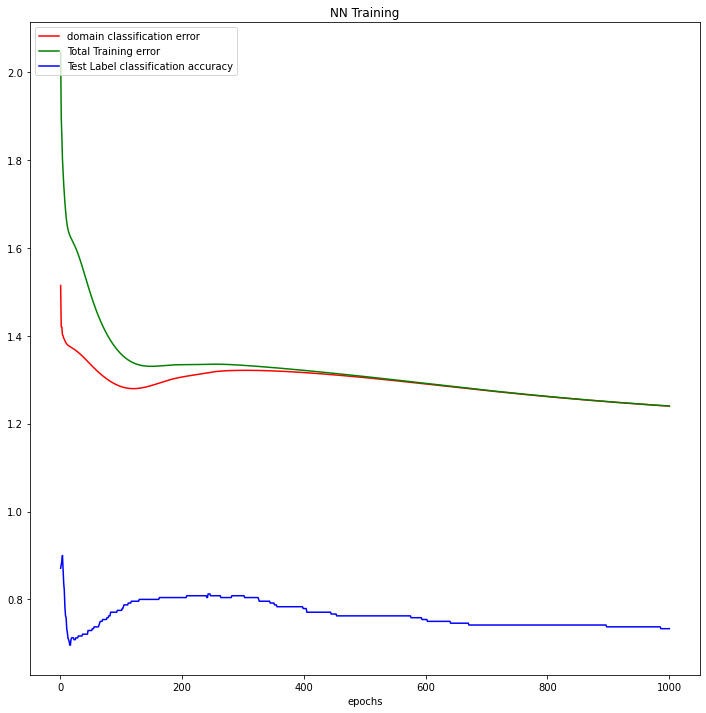

In [35]:
fig_width = 12
fig_height = 12
fig_dims = [fig_width,fig_height]
mode = "NN"
import matplotlib.pyplot as plt
epochs = np.arange(1,n_epoch+1)
plt.figure(1,figsize = fig_dims)
plt.title("NN Training")
plt.xlabel('epochs' )
plt.plot(epochs,domain_errs,'r',label="domain classification error")
plt.plot(epochs,train_errs,'g', label = "Total Training error")
plt.plot(epochs,test_accus,'b',label = "Test Label classification accuracy")
plt.legend(loc="upper left")
save_name = "NN_training_plot"
fig_name = fig_path + str(mode) + '_' + str(save_name) + '.png'
plt.savefig(fig_name)

In [0]:
# # # model =  torch.load(os.path.join(
# # #         model_root, '3706shallow_dann_epoch_996.pth'
# # #     ))
# # # model =  torch.load(os.path.join(
# # #       model_root, "8149src_only_shallow_dann_epoch_3.pth"
# # #   ))
# # model =  torch.load(os.path.join(
# #       model_root, "src_only_shallow_dann_epoch_999.pth"
# #   ))
# model =  torch.load(os.path.join(
#       model_root, "4868src_only_correct_shallow_dann_epoch_6.pth"
#   ))
# # print("Best epoch",best_epoch,"lr: ",lr,"best_b: ",best_b,"best_name: ",best_name)
# print("Best epoch",best_epoch,"lr: ",lr,"best_b: ",best_b)
# _,da1 = test_dann(model,"src", best_epoch)
# accu,da2 = test_dann(model,"tgt", best_epoch)
# domain_accu = (da1+da2)/2
# print("epoch: "+str(best_epoch)+", Domain accuracy: ",domain_accu)

In [0]:
# print(max_accu,best_b)

In [0]:
# b=""
# torch.save(model, ('{0}/'+str(b)+'src_only_shallow_dann_epoch_{1}.pth').format(model_root, epoch))

#Loading best models

In [0]:
best_model_dann = torch.load(os.path.join(
        model_root, '3706shallow_dann_epoch_996.pth'
    ))
best_model_src_only = torch.load(os.path.join(
      model_root, "4868src_only_fin_shallow_dann_epoch_999.pth"
  ))
best_model_dann.eval()
best_model_dann.to(device)
best_model_src_only.eval()
best_model_src_only.to(device)

#0 = NN,
#1 = DANN
test_dann(best_model_src_only,"src", 0)
test_dann(best_model_dann,"src", 1)

test_dann(best_model_src_only,"tgt", 0)
test_dann(best_model_dann,"tgt", 1)


epoch: 0, accuracy of the src dataset: 1.000000
epoch: 0, Domain accuracy of the src dataset: 0.579167
epoch: 1, accuracy of the src dataset: 1.000000
epoch: 1, Domain accuracy of the src dataset: 0.441667
epoch: 0, accuracy of the tgt dataset: 0.695833
epoch: 0, Domain accuracy of the tgt dataset: 0.595833
epoch: 1, accuracy of the tgt dataset: 0.983333
epoch: 1, Domain accuracy of the tgt dataset: 0.466667


(0.9833333333333333, 0.4666666666666667)

In [0]:
print(best_model_src_only)
print(best_model_dann)

NN(
  (feature): Sequential(
    (0): Linear(in_features=2, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (lc): Sequential(
    (0): Linear(in_features=15, out_features=2, bias=True)
    (1): LogSoftmax()
  )
  (dc): Sequential(
    (0): Linear(in_features=15, out_features=2, bias=True)
    (1): LogSoftmax()
  )
)
DANN(
  (feature): Sequential(
    (0): Linear(in_features=2, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (lc): Sequential(
    (0): Linear(in_features=15, out_features=2, bias=True)
    (1): LogSoftmax()
  )
  (dc): Sequential(
    (0): Linear(in_features=15, out_features=2, bias=True)
    (1): LogSoftmax()
  )
)


#Plotting

In [0]:
fig_width = 12
fig_height = 10
fig_dims = [fig_width,fig_height]

cnt_0 150 cnt_1 150


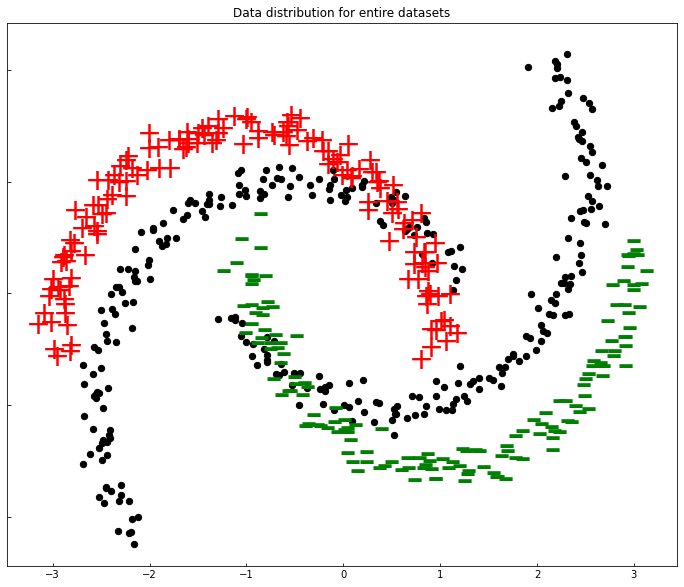

In [0]:
pyplot.figure(1,figsize=fig_dims)
pyplot.title("Data distribution for entire datasets")
# src_X, src_y, tgt_X, tgt_y
draw_trans_data(src_X, src_y, tgt_X)
# src_X, src_y, tgt_X, tgt_y = make_trans_moons(35, nb=300) #theta = 35,150 samples for each label
# plt.savefig('books_read.png')    
pyplot.savefig(fig_path+"Data_Distribution_entire.png")

cnt_0 121 cnt_1 119


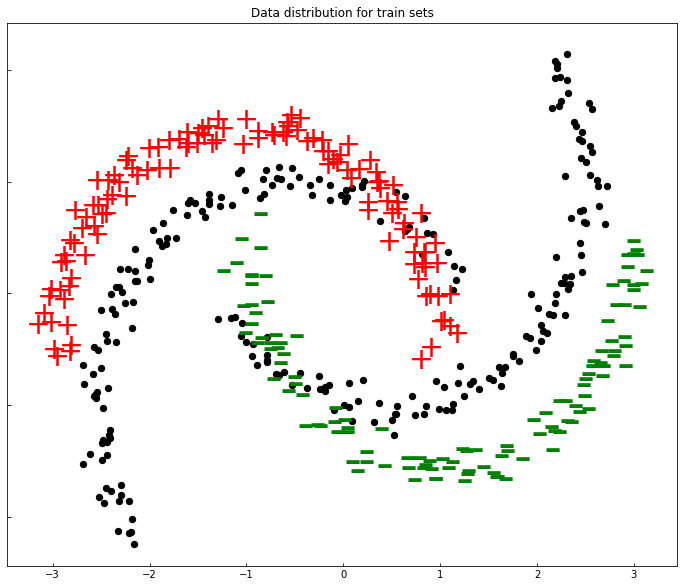

In [0]:
pyplot.figure(1,figsize=fig_dims)
pyplot.title("Data distribution for train sets")
# src_X, src_y, tgt_X, tgt_y
draw_trans_data(X_src_train, y_src_train, X_tgt_train)
# src_X, src_y, tgt_X, tgt_y = make_trans_moons(35, nb=300) #theta = 35,150 samples for each label
# plt.savefig('books_read.png')    
pyplot.savefig(fig_path+"Data_Distribution_train_sets.png")

cnt_0 29 cnt_1 31


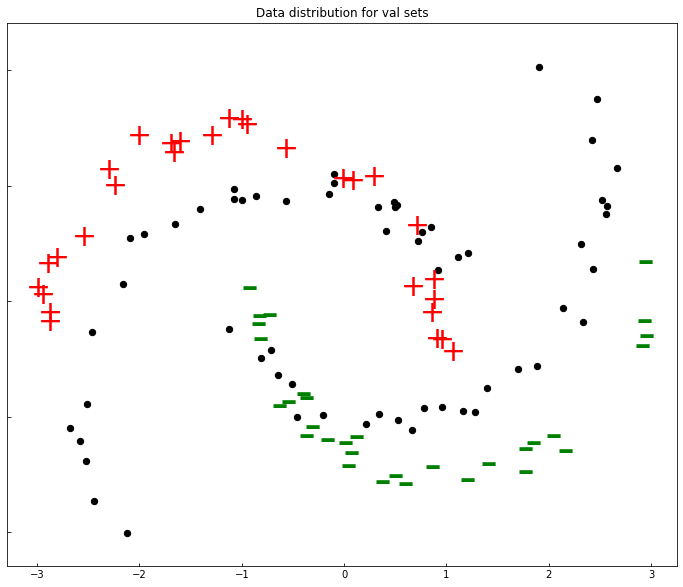

In [0]:
pyplot.figure(1,figsize=fig_dims)
pyplot.title("Data distribution for val sets")
# src_X, src_y, tgt_X, tgt_y
# X_src_train, X_src_test, y_src_train, y_src_test =  train_test_split(src_X, src_y, test_size = 0.2, random_state = 42,shuffle = True)
# X_tgt_train, X_tgt_test, y_tgt_train, y_tgt_test =  train_test_split(tgt_X, tgt_y, test_size = 0.2, random_state = 27,shuffle = True)
draw_trans_data(X_src_test, y_src_test, X_tgt_test)
pyplot.savefig(fig_path+"Data_Distribution_val_sets.png")
# draw_trans_data(src_X, src_y, tgt_X)
# pyplot.savefig(fig_path+"Data_Distribution_entire.png")

cnt_0 150 cnt_1 150


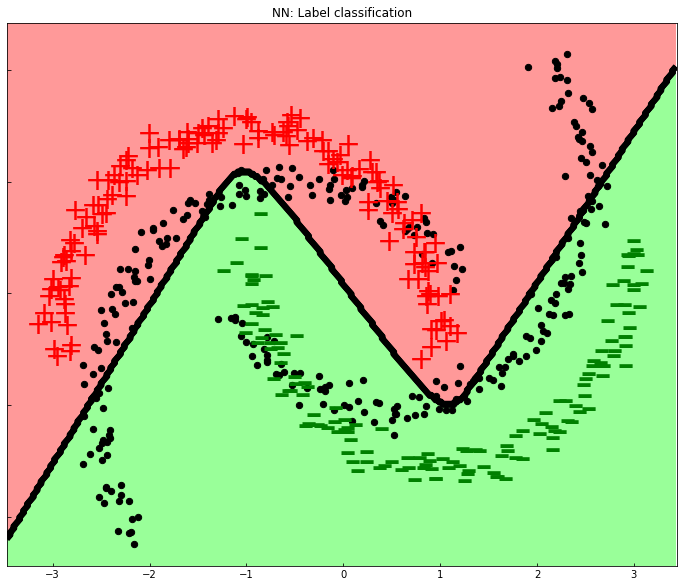

In [0]:
pyplot.figure(2,figsize=fig_dims)
pyplot.title("NN: Label classification")    
# draw_trans_data(X_src_test, y_src_test, X_tgt_test, best_model_src_only.predict)
draw_trans_data(src_X, src_y, tgt_X, best_model_src_only.predict)
pyplot.savefig(fig_path+"NN:Label_classification.png")

cnt_0 150 cnt_1 150


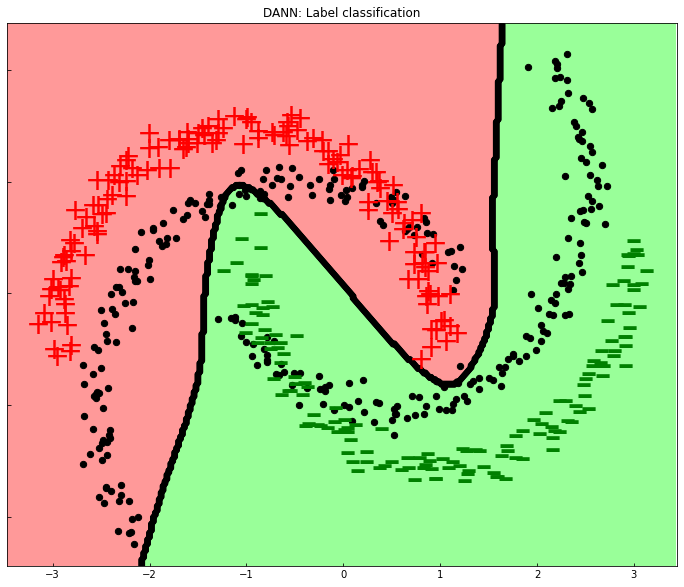

In [0]:
pyplot.figure(3,figsize=fig_dims)
pyplot.title("DANN: Label classification")    
# draw_trans_data(X_src_test, y_src_test, X_tgt_test, best_model_dann.predict)
draw_trans_data(src_X, src_y, tgt_X, best_model_dann.predict)
pyplot.savefig(fig_path+"NN:Label_classification.png")

cnt_0 150 cnt_1 150


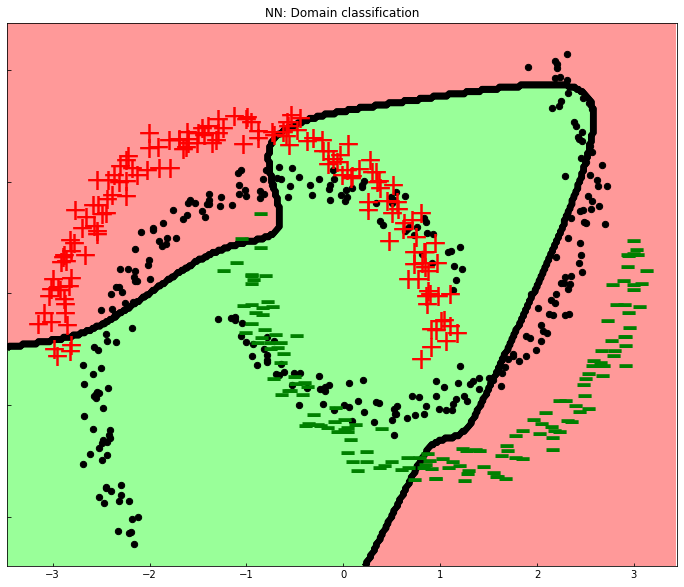

In [0]:
pyplot.figure(4,figsize=fig_dims)
pyplot.title("NN: Domain classification")    
# draw_trans_data(X_src_test, y_src_test, X_tgt_test, best_model_src_only.predict_domain)
draw_trans_data(src_X, src_y, tgt_X, best_model_src_only.predict_domain)
# draw_trans_data(src_X, src_y, tgt_X, best_model_dann.predict)
# pyplot.savefig(fig_path+"NN:Domain_classification.png")

cnt_0 150 cnt_1 150


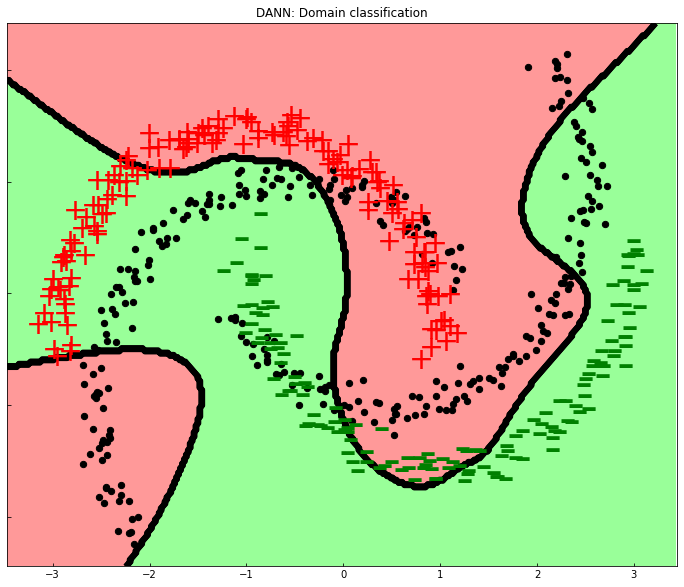

In [0]:
pyplot.figure(5,figsize=fig_dims)
pyplot.title("DANN: Domain classification")
# draw_trans_data(src_X, src_y, tgt_X, best_model_src_only.predict_domain)    
# draw_trans_data(X_src_test, y_src_test, X_tgt_test, best_model_dann.predict_domain)
draw_trans_data(src_X, src_y, tgt_X, best_model_dann.predict_domain)
# pyplot.savefig(fig_path+"DANN:Domain_classification.png")